### Read heavy quark data from files 
Using Julia

In [1]:
using Pickle

Qs = 2.0
results = ["wong", "kappa"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = data_wong["quarks"]
pTs = string.(data_wong["pTs"])

SystemError: SystemError: opening file "mom_broad_wong.pickle": No such file or directory

### Plot heavy quark momentum broadening 
Using Makie from Julia

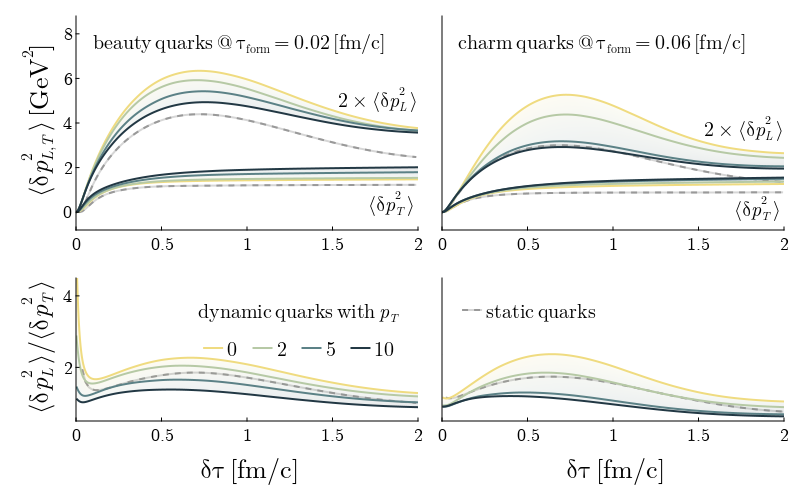

In [2]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (800, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p_{L,T}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 26, ylabelsize= 26, xticklabelsize=18, yticklabelsize=18,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=(:grey60, 0.4))

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 2, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 2, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 2, color=colors[ipT]))
    end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)
ylims!(axes[2][1], 0.5, 4.5)
axes[2][1].yticks = ([2,4, 6], string.([2, 4, 6]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"\mathrm{dynamic\,quarks\,with\,}p_T", labelsize=20, 
        titleposition = :top, titlesize=20, position = :rt, orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[2][2], [[kappa, kappa_dash]], legend_kappa, labelsize=20, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)
text!(axes[1][2], L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,4.4), textsize=20)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.72,-0.3), textsize=20)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,3.1), textsize=20)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.72, -0.5), textsize=20)

display(fig)
# save("mom_broad_wong_vs_kappa_qm_proc_v3.png", fig, px_per_unit = 5.0) 

### Read jet data from files 
Using Julia

In [62]:
results = ["wong_jets_px_dep", "wong_jets_mass_dep", "qhat"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "mom_broad_" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname("mom_broad_" * r,  data["mom_broad"])
    string_as_varname("tau_" * r,  data["tau"])
end

pxs, mass = string.(data_wong_jets_px_dep["pxs"]), string.(data_wong_jets_px_dep["mass"])
masses, px = string.(data_wong_jets_mass_dep["masses"]), string.(data_wong_jets_mass_dep["px"])

(["5", "10", "25", "50"], "50")

### Plot jet momentum broadening 
Using Makie from Julia

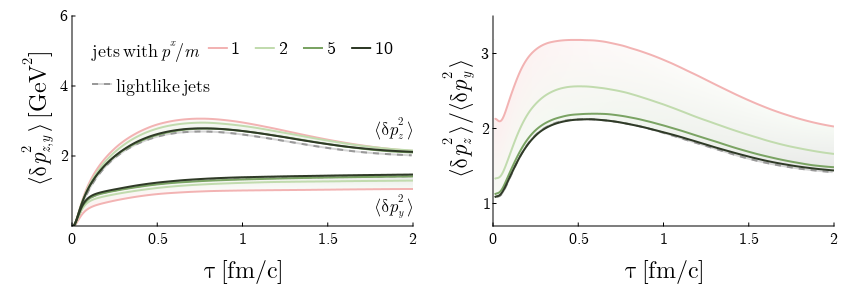

In [10]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:watermelon, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (850, 300), font = "CMU Serif")
ylabels = [L"\langle\delta p_{z,y}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_z\,\rangle/\langle\delta p^2_y\,\rangle"]
axes = [Axis(fig[1, i], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 24, ylabelsize= 24, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

δτ_qhat = Float64.(tau_qhat)
mom_broad_L_qhat = mom_broad_qhat[:, 3]/DR
lines!(axes[1], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=(:grey60, 0.4))
mom_broad_T_qhat = mom_broad_qhat[:, 2] /DR
lines!(axes[1], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=(:grey60, 0.4))
ratio = mom_broad_L_qhat./mom_broad_T_qhat
global qhat_dash = lines!(axes[2], δτ_qhat, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
global qhat = lines!(axes[2], δτ_qhat, ratio, linewidth = 2, color=(:grey60, 0.4))


# px dependence 
tag_low, tag_high = "mass_" * mass * "_px_" * pxs[1], "mass_" * mass * "_px_" * pxs[length(pxs)]
δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_px_dep[tag_low][:, 3]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 3]/DR
band!(axes[1], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 2]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 2]/DR
band!(axes[1], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[2], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))

for ip in 1:length(pxs)
        tag_wong_jets = "mass_" * mass * "_px_" * pxs[ip]
        δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 3]/DR
        lines!(axes[1], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 2, color=colors[ip])
        mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]/DR
        lines!(axes[1], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 2, color=colors[ip])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_px_"*string(ip), lines!(axes[2], δτ_wong_jets, ratio, linewidth = 2, color=colors[ip]))
end


for i in 1:2
        xlims!(axes[i], 0, 2)
        axes[i].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
end

linkxaxes!(axes[1], axes[2])
ylims!(axes[1], 0, 6)
axes[1].yticks = ([2, 4, 6], string.([2, 4, 6]))
ylims!(axes[2], 0.7, 3.5)
axes[2].yticks = ([1, 2, 3], string.([1, 2, 3]))

legend_wong_px = string.(floor.(Int,(parse.(Int64, pxs))./10))
axislegend(axes[1], [wong_px_1, wong_px_2, wong_px_3, wong_px_4], legend_wong_px, L"\mathrm{jets\,with\,}p^x/m", labelsize=18, 
        titleposition = :left, titlesize=18, position = :lt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_qhat = [L"\mathrm{lightlike\,jets}"]
axislegend(axes[1], [[qhat, qhat_dash]], legend_qhat, labelsize=18, position = (0, 0.75), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1], L"\langle\delta p_z^2\,\rangle", position = (1.78,2.4), textsize=18)
text!(axes[1], L"\langle\delta p_y^2\,\rangle", position = (1.78, 0.2), textsize=18)

display(fig)
# save("mom_broad_wong_vs_qhat_qm_proc_v2.png", fig, px_per_unit = 5.0) 

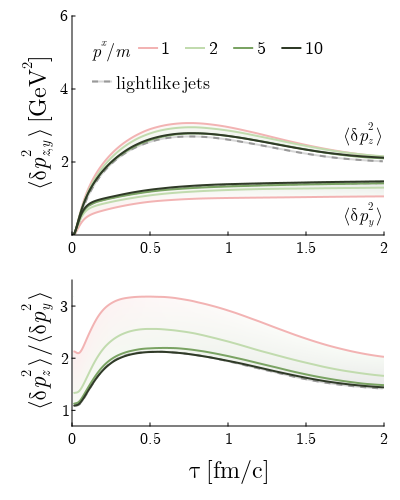

In [11]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:watermelon, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (400, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p_{z,y}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_z\,\rangle/\langle\delta p^2_y\,\rangle"]
axes = [Axis(fig[i, 1], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 24, ylabelsize= 24, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

δτ_qhat = Float64.(tau_qhat)
mom_broad_L_qhat = mom_broad_qhat[:, 3]/DR
lines!(axes[1], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=(:grey60, 0.4))
mom_broad_T_qhat = mom_broad_qhat[:, 2] /DR
lines!(axes[1], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=(:grey60, 0.4))
ratio = mom_broad_L_qhat./mom_broad_T_qhat
global qhat_dash = lines!(axes[2], δτ_qhat, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
global qhat = lines!(axes[2], δτ_qhat, ratio, linewidth = 2, color=(:grey60, 0.4))


# px dependence 
tag_low, tag_high = "mass_" * mass * "_px_" * pxs[1], "mass_" * mass * "_px_" * pxs[length(pxs)]
δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_px_dep[tag_low][:, 3]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 3]/DR
band!(axes[1], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 2]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 2]/DR
band!(axes[1], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[2], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))

for ip in 1:length(pxs)
        tag_wong_jets = "mass_" * mass * "_px_" * pxs[ip]
        δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 3]/DR
        lines!(axes[1], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 2, color=colors[ip])
        mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]/DR
        lines!(axes[1], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 2, color=colors[ip])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_px_"*string(ip), lines!(axes[2], δτ_wong_jets, ratio, linewidth = 2, color=colors[ip]))
end


for i in 1:2
        xlims!(axes[i], 0, 2)
        axes[i].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
end

linkxaxes!(axes[1], axes[2])
hidexdecorations!(axes[1], ticks = false, ticklabels = false)

ylims!(axes[1], 0, 6)
axes[1].yticks = ([2, 4, 6], string.([2, 4, 6]))
ylims!(axes[2], 0.7, 3.5)
axes[2].yticks = ([1, 2, 3], string.([1, 2, 3]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_px = string.(floor.(Int,(parse.(Int64, pxs))./10))
axislegend(axes[1], [wong_px_1, wong_px_2, wong_px_3, wong_px_4], legend_wong_px, L"p^x/m", labelsize=18, 
        titleposition = :left, titlesize=18, position = :lt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_qhat = [L"\mathrm{lightlike\,jets}"]
axislegend(axes[1], [[qhat, qhat_dash]], legend_qhat, labelsize=18, position = (0, 0.78), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1], L"\langle\delta p_z^2\,\rangle", position = (1.75,2.4), textsize=18)
text!(axes[1], L"\langle\delta p_y^2\,\rangle", position = (1.75, 0.2), textsize=18)

display(fig)
# save("mom_broad_wong_vs_qhat_qm_proc_v3.png", fig, px_per_unit = 5.0) 

### Plot heavy quark and jet momentum broadening 
Using Makie from Julia

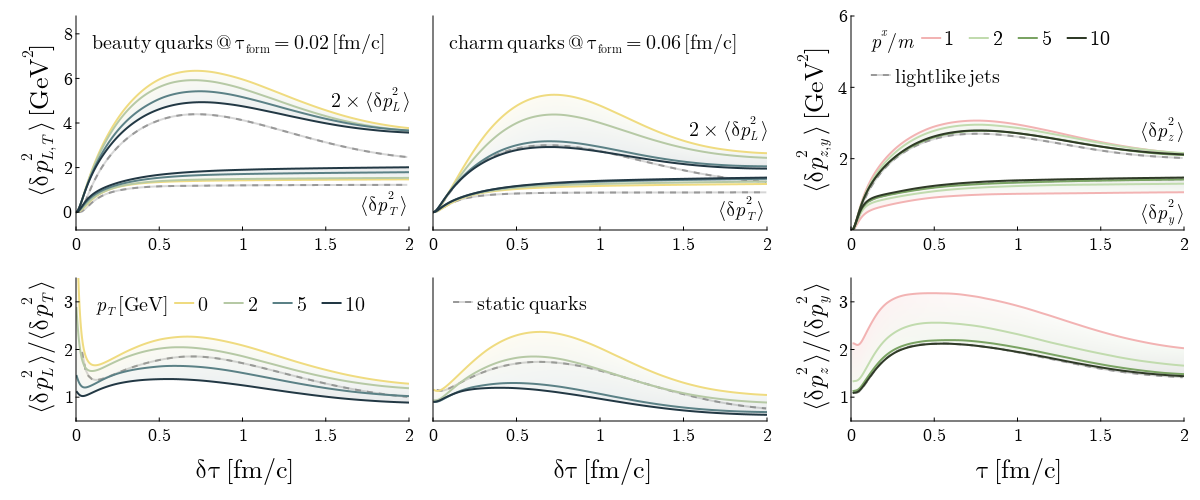

In [5]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1200, 500), font = "CMU Serif")
ylabels = [[L"\langle\delta p_{L,T}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"], 
        [L"\langle\delta p_{L,T}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"],
        [L"\langle\delta p_{z,y}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_z\,\rangle/\langle\delta p^2_y\,\rangle"]]
xlabels = [L"\delta\tau\,\mathrm{[fm/c]}", L"\delta\tau\,\mathrm{[fm/c]}", L"\tau\,\mathrm{[fm/c]}"]
axes = [[Axis(fig[i, j], 
        xlabel=xlabels[j], ylabel=ylabels[j][i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 26, ylabelsize= 26, xticklabelsize=18, yticklabelsize=18,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:3] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=(:grey60, 0.4))

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 2, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 2, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 2, color=colors[ipT]))
    end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:3
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:3
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)
ylims!(axes[2][1], 0.5, 3.5)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=20, 
        titleposition = :left, titlesize=20, position = (0, 1.1), orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[2][2], [[kappa, kappa_dash]], legend_kappa, labelsize=20, position = (0, 1.1), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)
text!(axes[1][2], L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,4.4), textsize=20)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.72,-0.3), textsize=20)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,3.1), textsize=20)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.72, -0.5), textsize=20)

segmented_cmap = cgrad(:watermelon, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

δτ_qhat = Float64.(tau_qhat)
mom_broad_L_qhat = mom_broad_qhat[:, 3]/DR
lines!(axes[1][3], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1][3], δτ_qhat, mom_broad_L_qhat, linewidth = 2, color=(:grey60, 0.4))
mom_broad_T_qhat = mom_broad_qhat[:, 2] /DR
lines!(axes[1][3], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=:grey60, linestyle=:dash)
lines!(axes[1][3], δτ_qhat, mom_broad_T_qhat, linewidth = 2, color=(:grey60, 0.4))
ratio = mom_broad_L_qhat./mom_broad_T_qhat
global qhat_dash = lines!(axes[2][3], δτ_qhat, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
global qhat = lines!(axes[2][3], δτ_qhat, ratio, linewidth = 2, color=(:grey60, 0.4))

# px dependence 
tag_low, tag_high = "mass_" * mass * "_px_" * pxs[1], "mass_" * mass * "_px_" * pxs[length(pxs)]
δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_px_dep[tag_low][:, 3]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 3]/DR
band!(axes[1][3], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 2]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 2]/DR
band!(axes[1][3], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[2][3], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))

for ip in 1:length(pxs)
        tag_wong_jets = "mass_" * mass * "_px_" * pxs[ip]
        δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 3]/DR
        lines!(axes[1][3], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 2, color=colors[ip])
        mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]/DR
        lines!(axes[1][3], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 2, color=colors[ip])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_px_"*string(ip), lines!(axes[2][3], δτ_wong_jets, ratio, linewidth = 2, color=colors[ip]))
end


ylims!(axes[1][3], 0, 6)
axes[1][3].yticks = ([2, 4, 6], string.([2, 4, 6]))
ylims!(axes[2][3], 0.5, 3.5)
axes[2][3].yticks = ([1, 2, 3], string.([1, 2, 3]))

legend_wong_px = string.(floor.(Int,(parse.(Int64, pxs))./10))
axislegend(axes[1][3], [wong_px_1, wong_px_2, wong_px_3, wong_px_4], legend_wong_px, L"p^x/m", labelsize=20, 
        titleposition = :left, titlesize=20, position = (0, 1.08), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_qhat = [L"\mathrm{lightlike\,jets}"]
axislegend(axes[1][3], [[qhat, qhat_dash]], legend_qhat, labelsize=20, position = (0, 0.82), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][3], L"\langle\delta p_z^2\,\rangle", position = (1.75,2.4), textsize=20)
text!(axes[1][3], L"\langle\delta p_y^2\,\rangle", position = (1.75, 0.1), textsize=20)

display(fig)
# save("mom_broad_wong_vs_kappa_vs_qhat_qm_proc.png", fig, px_per_unit = 5.0) 

### Final version of the plot

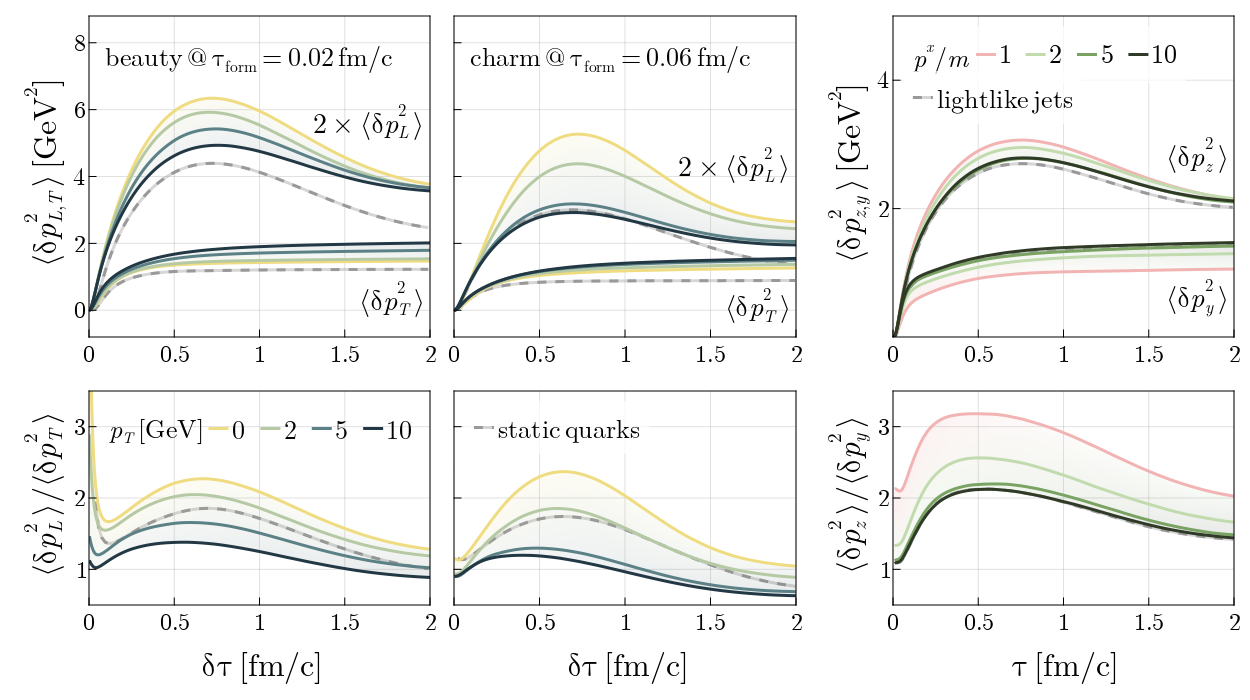

In [7]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1250, 700), font = "CMU Serif")
ylabels = [[L"\langle\delta p_{L,T}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"], 
        [L"\langle\delta p_{L,T}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"],
        [L"\langle\delta p_{z,y}^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_z\,\rangle/\langle\delta p^2_y\,\rangle"]]
xlabels = [L"\delta\tau\,\mathrm{[fm/c]}", L"\delta\tau\,\mathrm{[fm/c]}", L"\tau\,\mathrm{[fm/c]}"]
axes = [[Axis(fig[i, j], 
        xlabel=xlabels[j], ylabel=ylabels[j][i],
        xlabelsize = 32, ylabelsize= 32, xticklabelsize=24, yticklabelsize=24,
        # ylabeloffset = 100,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=8, 
        # xgridvisible = false, ygridvisible = false
        ) for j in 1:3] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 3, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 3, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 3, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 3, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 3, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 3, color=(:grey60, 0.4))

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 3, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 3, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 3, color=colors[ipT]))
    end
end

ylims!(axes[2][1], 0.5, 3.5)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))
axes[2][2].yticks = ([1, 2, 3], string.([1, 2, 3]))

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false, ticks = false)
        for j in 1:3
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:3
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false, grid = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=26, 
        titleposition = :left, titlesize=26, position = (0, 1), orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[2][2], [[kappa, kappa_dash]], legend_kappa, labelsize=26, position = (0, 1), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{fm/c}", position = (0.1,7), textsize=26)
text!(axes[1][2], L"\mathrm{charm\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{fm/c}", position = (0.1,7), textsize=26)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.32,5), textsize=28)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.6,-0.3), textsize=28)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.32,3.7), textsize=28)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.6, -0.5), textsize=28)

segmented_cmap = cgrad(:watermelon, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

δτ_qhat = Float64.(tau_qhat)
mom_broad_L_qhat = mom_broad_qhat[:, 3]/DR
lines!(axes[1][3], δτ_qhat, mom_broad_L_qhat, linewidth = 3, color=:grey60, linestyle=:dash)
lines!(axes[1][3], δτ_qhat, mom_broad_L_qhat, linewidth = 3, color=(:grey60, 0.4))
mom_broad_T_qhat = mom_broad_qhat[:, 2] /DR
lines!(axes[1][3], δτ_qhat, mom_broad_T_qhat, linewidth = 3, color=:grey60, linestyle=:dash)
lines!(axes[1][3], δτ_qhat, mom_broad_T_qhat, linewidth = 3, color=(:grey60, 0.4))
ratio = mom_broad_L_qhat./mom_broad_T_qhat
global qhat_dash = lines!(axes[2][3], δτ_qhat, ratio, linewidth = 3, color=:grey60, linestyle=:dash)
global qhat = lines!(axes[2][3], δτ_qhat, ratio, linewidth = 3, color=(:grey60, 0.4))


# px dependence 
tag_low, tag_high = "mass_" * mass * "_px_" * pxs[1], "mass_" * mass * "_px_" * pxs[length(pxs)]
δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong_jets_px_dep[tag_low][:, 3]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 3]/DR
band!(axes[1][3], δτ_wong_jets, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
mom_broad_T_low, mom_broad_T_high = mom_broad_wong_jets_px_dep[tag_low][:, 2]/DR , mom_broad_wong_jets_px_dep[tag_high][:, 2]/DR
band!(axes[1][3], δτ_wong_jets, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high
band!(axes[2][3], δτ_wong_jets, ratio_low, ratio_high; color = transpose(reverse(δτ_wong_jets)), colormap = (:watermelon, 0.1))

for ip in 1:length(pxs)
        tag_wong_jets = "mass_" * mass * "_px_" * pxs[ip]
        δτ_wong_jets = Float64.(tau_wong_jets_px_dep[tag_wong_jets])

        mom_broad_L_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 3]/DR
        lines!(axes[1][3], δτ_wong_jets, mom_broad_L_wong_jets, linewidth = 3, color=colors[ip])
        mom_broad_T_wong_jets = mom_broad_wong_jets_px_dep[tag_wong_jets][:, 2]/DR
        lines!(axes[1][3], δτ_wong_jets, mom_broad_T_wong_jets, linewidth = 3, color=colors[ip])
        ratio = mom_broad_L_wong_jets./mom_broad_T_wong_jets
        string_as_varname("wong_px_"*string(ip), lines!(axes[2][3], δτ_wong_jets, ratio, linewidth = 3, color=colors[ip]))
end


ylims!(axes[1][3], 0, 5)
axes[1][3].yticks = ([2, 4], string.([2, 4]))
ylims!(axes[2][3], 0.5, 3.5)
axes[2][3].yticks = ([1, 2, 3], string.([1, 2, 3]))

legend_wong_px = string.(floor.(Int,(parse.(Int64, pxs))./10))
axislegend(axes[1][3], [wong_px_1, wong_px_2, wong_px_3, wong_px_4], legend_wong_px, L"p^x/m", labelsize=26, 
        titleposition = :left, titlesize=26, position = (0, 1), orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_qhat = [L"\mathrm{lightlike\,jets}"]
axislegend(axes[1][3], [[qhat, qhat_dash]], legend_qhat, labelsize=26, position = (0, 0.82), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][3], L"\langle\delta p_z^2\,\rangle", position = (1.62, 2.5), textsize=28)
text!(axes[1][3], L"\langle\delta p_y^2\,\rangle", position = (1.62, 0.3), textsize=28)

display(fig)
# save("mom_broad_wong_vs_kappa_vs_qhat_qm_proc_v2_nogrid.png", fig, px_per_unit = 5.0) 

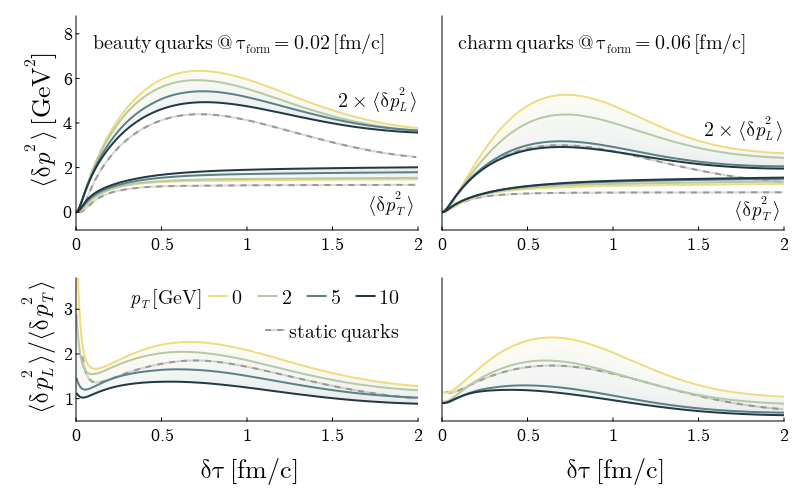

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x000000000b005c10, 600.0, 375.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/mom_broad_wong_vs_kappa_all.pdf>)))


In [3]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (800, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 26, ylabelsize= 26, xticklabelsize=18, yticklabelsize=18,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=(:grey60, 0.4))

    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 2, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 2, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 2, color=colors[ipT]))
    end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)
ylims!(axes[2][1], 0.5, 3.7)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=20, 
        titleposition = :left, titlesize=20, position = (1,1.2), orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[2][1], [[kappa, kappa_dash]], legend_kappa, labelsize=20, position = (1,0.75), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)
text!(axes[1][2], L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,4.4), textsize=20)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.72,-0.3), textsize=20)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,3.1), textsize=20)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.72, -0.5), textsize=20)

display(fig)
# save("mom_broad_wong_vs_kappa_all.png", fig, px_per_unit = 5.0) 
save("mom_broad_wong_vs_kappa_all.pdf", fig) 

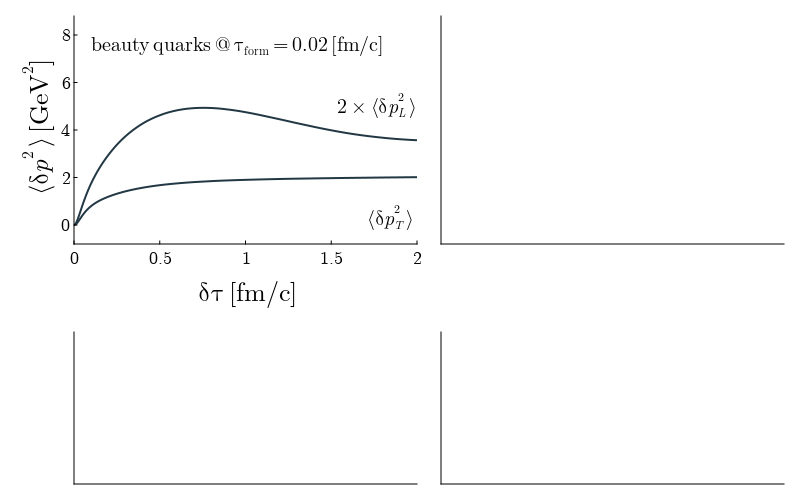

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x0000000013d32b00, 4000.0, 2500.0)


In [49]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (800, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 26, ylabelsize= 26, xticklabelsize=18, yticklabelsize=18,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
for iq in 1:1
#     tag_kappa = quarks[iq]
#     δτ_kappa = Float64.(tau_kappa[tag_kappa])
#     mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
#     lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
#     lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=(:grey60, 0.4))
#     mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
#     lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
#     lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=(:grey60, 0.4))
#     ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
#     global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
#     global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=(:grey60, 0.4))

    # band
#     tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
#     δτ_wong = Float64.(tau_wong[tag_low])
#     mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
#     band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
#     mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
#     band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
#     ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
#     band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

#     for ipT in 1:length(pTs)
        ipT = 4
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 2, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 2, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        # string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 2, color=colors[ipT]))
#     end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j])
        # hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)
ylims!(axes[2][1], 0.5, 3.7)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

# legend_wong_pT = [L"0", L"2", L"5", L"10"]
# axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=20, 
#         titleposition = :left, titlesize=20, position = (1,1.2), orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

# legend_kappa = [L"\mathrm{static\,quarks}"]
# axislegend(axes[2][1], [[kappa, kappa_dash]], legend_kappa, labelsize=20, position = (1,0.75), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)
# text!(axes[1][2], L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,4.4), textsize=20)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.72,-0.3), textsize=20)

# text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,3.1), textsize=20)
# text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.72, -0.5), textsize=20)


hidexdecorations!(axes[1][2], grid = false)
hidexdecorations!(axes[2][2], grid = false)
hidexdecorations!(axes[2][1], grid = false)
hideydecorations!(axes[2][1], grid = false)
display(fig)
save("mom_broad_wong_vs_kappa_all_1.png", fig, px_per_unit = 5.0) 

In [ ]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[10], segmented_cmap[6], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (800, 500), font = "CMU Serif")
ylabels = [L"\langle\delta p^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [[Axis(fig[i, j], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 26, ylabelsize= 26, xticklabelsize=18, yticklabelsize=18,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for j in 1:2] for i in 1:2]

# dimenstion of fundamental representation for SU(3)
DR = 3

# factor
factor = 2

i = 1
# for iq in 1:1
for iq in 1:2
    tag_kappa = quarks[iq]
    δτ_kappa = Float64.(tau_kappa[tag_kappa])
    mom_broad_L_kappa = mom_broad_kappa[tag_kappa][:, 3]/DR*factor
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_L_kappa, linewidth = 2, color=(:grey60, 0.4))
    mom_broad_T_kappa = (mom_broad_kappa[tag_kappa][:, 1]+mom_broad_kappa[tag_kappa][:, 2])/DR
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=:grey60, linestyle=:dash)
    lines!(axes[1][iq], δτ_kappa, mom_broad_T_kappa, linewidth = 2, color=(:grey60, 0.4))
    ratio = mom_broad_L_kappa./factor./mom_broad_T_kappa
    global kappa_dash = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=:grey60, linestyle=:dash)
    global kappa = lines!(axes[2][iq], δτ_kappa, ratio, linewidth = 2, color=(:grey60, 0.4))

    # band
    tag_low, tag_high = quarks[iq] * "_pT_" * pTs[1], quarks[iq] * "_pT_" * pTs[4]
    δτ_wong = Float64.(tau_wong[tag_low])
    mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3]/DR*factor, mom_broad_wong[tag_high][:, 3]/DR*factor
    band!(axes[1][iq], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    mom_broad_T_low, mom_broad_T_high = (mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2])/DR, (mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2])/DR
    band!(axes[1][iq], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))
    ratio_low, ratio_high = mom_broad_L_low./factor./mom_broad_T_low, mom_broad_L_high./factor./mom_broad_T_high
    band!(axes[2][iq], δτ_wong, ratio_low, ratio_high; color = transpose(reverse(δτ_wong)), colormap = (:starrynight, 0.1))

    for ipT in 1:length(pTs)
        # ipT = 4
        tag_wong = quarks[iq] * "_pT_" * pTs[ipT]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/DR*factor
        lines!(axes[1][iq], δτ_wong, mom_broad_L_wong, linewidth = 2, color=colors[ipT])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/DR
        lines!(axes[1][iq], δτ_wong, mom_broad_T_wong, linewidth = 2, color=colors[ipT])
        ratio = mom_broad_L_wong./factor./mom_broad_T_wong
        string_as_varname("wong_pT_"*string(ipT), lines!(axes[2][iq], δτ_wong, ratio, linewidth = 2, color=colors[ipT]))
    end
end

for i in 1:2
        linkyaxes!(axes[i][1], axes[i][2])
        hideydecorations!(axes[i][2], grid = false)
        for j in 1:2
                xlims!(axes[i][j], 0, 2)
                axes[i][j].xticks = ([0, 0.5, 1, 1.5, 2], ["0", "0.5", "1", "1.5", "2"])
        end
end

for j in 1:2
        linkxaxes!(axes[1][j], axes[2][j])
        hidexdecorations!(axes[1][j], ticks = false, ticklabels = false)
end

ylims!(axes[1][1], -0.8, 8.8)
ylims!(axes[1][2], -0.8, 8.8)
ylims!(axes[2][1], 0.5, 3.7)
axes[2][1].yticks = ([1, 2, 3], string.([1, 2, 3]))

rowsize!(fig.layout, 1, Relative(3/5))
rowsize!(fig.layout, 2, Relative(2/5))

legend_wong_pT = [L"0", L"2", L"5", L"10"]
axislegend(axes[2][1], [wong_pT_1, wong_pT_2, wong_pT_3, wong_pT_4], legend_wong_pT, L"p_T\,\mathrm{[GeV]}", labelsize=20, 
        titleposition = :left, titlesize=20, position = (1,1.2), orientation = :horizontal, bgcolor = (:white, 0), framecolor=(:grey80, 0))

legend_kappa = [L"\mathrm{static\,quarks}"]
axislegend(axes[2][1], [[kappa, kappa_dash]], legend_kappa, labelsize=20, position = (1,0.75), orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(axes[1][1], L"\mathrm{beauty\,quarks\,@\,}\tau_\mathrm{form}=0.02\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)
text!(axes[1][2], L"\mathrm{charm\,quarks\,@\,}\tau_\mathrm{form}=0.06\,\mathrm{[fm/c]}", position = (0.1,7), textsize=20)

text!(axes[1][1], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,4.4), textsize=20)
text!(axes[1][1], L"\langle\delta p_T^2\,\rangle", position = (1.72,-0.3), textsize=20)

text!(axes[1][2], L"2\times\langle\delta p_L^2\,\rangle", position = (1.54,3.1), textsize=20)
text!(axes[1][2], L"\langle\delta p_T^2\,\rangle", position = (1.72, -0.5), textsize=20)


# hidexdecorations!(axes[1][2], grid = false)
# hidexdecorations!(axes[2][2], grid = false)
# hidexdecorations!(axes[2][1], grid = false)
# hideydecorations!(axes[2][1], grid = false)
display(fig)
save("mom_broad_wong_vs_kappa_all_5.png", fig, px_per_unit = 5.0) 